# Diffusion 扩散模型 之 DDPM


这是 diffusion 扩散模型系列第五部分，自2020年谷歌发表 DDPM 后，扩散模型逐渐成为了生成领域的一个新热点，接下来我们一起揭开 DDPM的神秘面纱。

本部分包括以下内容：
  1. 概率模型
  2. 损失函数
  3. EMA
  
笔记参考：https://github.com/acids-ircam/diffusion_models

## 1 概率模型

Ho et al. [ [ 1 ] ](#ref1) 提出了一些可以提高结果质量的扩散模型改进方案，首先对于均值函数使用如下参数化方法：
$$
\mathbf{\mu}_{\theta}(\mathbf{x}_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}} \left( (\mathbf{x}_{t} - \frac{\beta_{t}}{\sqrt{1 - \bar{\alpha}}_{t}} \mathbf{\epsilon}_{\theta} (\mathbf{x}_{t}, t) \right) 
$$

另外提出使用固定的方差函数：

$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$

这导致在反向过程中使用新的采样流程,具体做法如下：

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from models.net import ConditionalLinear
from utils.helper import sample_batch,extract,make_beta_schedule,p_sample_loop

class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)
    
def p_sample(model, x, t,alphas):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

def p_sample_loop(model, shape,n_steps,alphas):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i,alphas)
        x_seq.append(cur_x)
    return x_seq

前向过程的后验分布是以 $\mathbf{x}_{0}$ 为条件并且是tractable的：

\begin{align}
q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}, \mathbf{x}_{0}\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \tilde{\boldsymbol{\mu}}_{t}\left(\mathbf{x}_{t}, \mathbf{x}_{0}\right), \tilde{\beta}_{t} \mathbf{I}\right)
\end{align}

相应的均值 $\tilde{\mathbf{\mu}}_{t}(\mathbf{x}_{t},\mathbf{x}_{0})$ 和方差 $\tilde{\beta}$ 为：

\begin{align}
\tilde{\mathbf{\mu}}_{t}(\mathbf{x}_{t},\mathbf{x}_{0}) &= \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_{t}}{1 - \bar{\alpha}_{t}}\mathbf{x}_{0} + \frac{\sqrt{\bar{\alpha}_{t}}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_{t}}\mathbf{x}_{t}\\
\tilde{\beta}_{t} &= \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_{t}}\beta_{t}
\end{align}

## 2 损失函数

损失函数 $\mathcal{L}$ 可以简化成如下 KL 散度之和：

\begin{align}
\mathcal{L} &= \mathbb{E}_{q}\left[ \mathcal{L}_{T} + \sum_{t>1} \mathcal{L}_{t-1} + \mathcal{L}_{0} \right] \\
\mathcal{L}_{T} &= D_{KL}(q(\mathbf{x}_{T}\mid\mathbf{x}_{0}) \Vert p(\mathbf{x}_{T})) \\
\mathcal{L}_{t-1} &= D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})) \\
\mathcal{L}_{0} &= - \log p_{\theta}(\mathbf{x}_{0}\mid\mathbf{x}_{1}) 
\end{align}

式中， KL 散度比较的是高斯分布，所以有解析解， 其中 $\mathcal{L}_{T}$ 为常数可忽略，只需要计算 $\mathcal{L}_{t-1}$ 和 $\mathcal{L}_{0}$ 。

首先定义一些计算工具：

In [2]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

损失函数的计算如下：

In [3]:
def loss_variational(model, x_0):
    batch_size = x_0.shape[0]
    
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
   
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    
    # Compute the KL loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)
    
    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)
    
    # At the first timestep return the decoder NLL, otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    return output.mean(-1)

因为 DDPM 对均值函数使用了新的参数化方法：
$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1 - \alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$

可以对损失函数做进一步简化：
$$
\mathcal{L}_{t-1}-C=\mathbb{E}_{\mathbf{x}_{0},\mathbf{\epsilon}}\left[ \frac{\beta_{t}^{2}}{2\sigma_{t}^{2}\alpha_{t}(1-\bar{\alpha}_{t})} \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right]
$$

作者发现去除损失函数前面的复杂因子有利于提高样本生成质量，所以损失函数进一步简化为：

$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right].
$$

可见此时的目标非常类似于 denoising score matching ，以 $t$ 为索引，集成了多个噪声尺度，并且实现方式更加简洁：

In [4]:
def noise_estimation_loss(model, x_0,n_steps):
    batch_size = x_0.shape[0]
    
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

## 3 EMA 

指数移动平均 Exponential Moving Average (EMA)是常常用到的训练trick，不同于直接更新模型权重，首先保留一些之前的权重，然后基于当前权重和之前的权重得到更新的权重均值，这里参考[DDIM repository](https://github.com/ermongroup/ddim) 的代码：

In [5]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

训练过程定义如下：

tensor(1.2423, grad_fn=<MeanBackward0>)
tensor(0.7347, grad_fn=<MeanBackward0>)
tensor(0.7588, grad_fn=<MeanBackward0>)
tensor(0.6059, grad_fn=<MeanBackward0>)
tensor(0.4400, grad_fn=<MeanBackward0>)
tensor(0.8424, grad_fn=<MeanBackward0>)
tensor(1.5564, grad_fn=<MeanBackward0>)
tensor(0.6895, grad_fn=<MeanBackward0>)
tensor(0.6837, grad_fn=<MeanBackward0>)
tensor(0.4916, grad_fn=<MeanBackward0>)


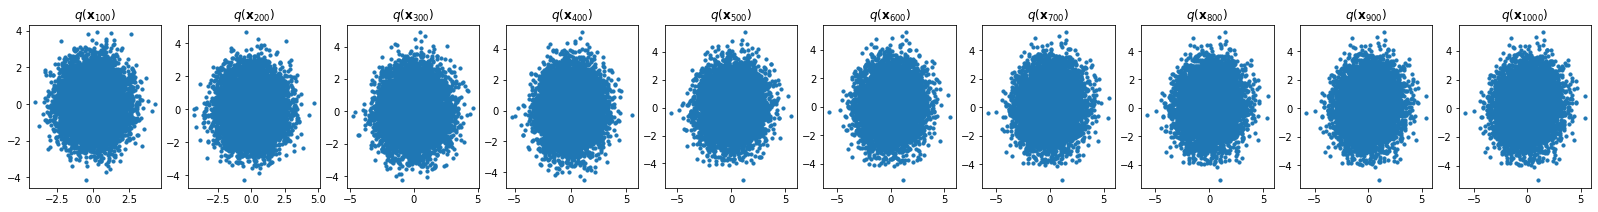

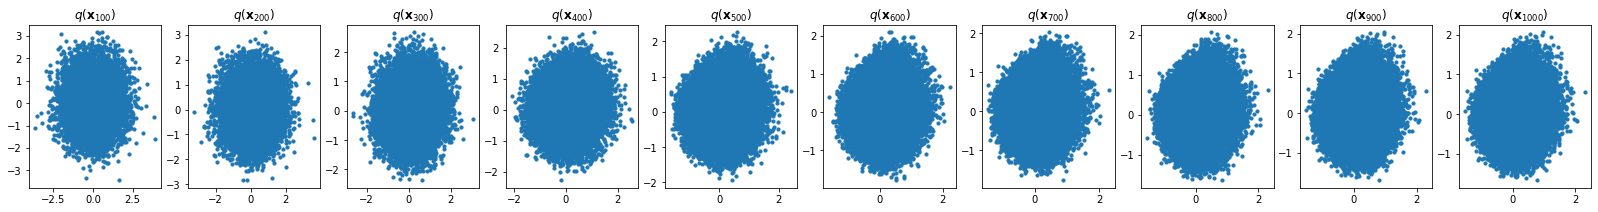

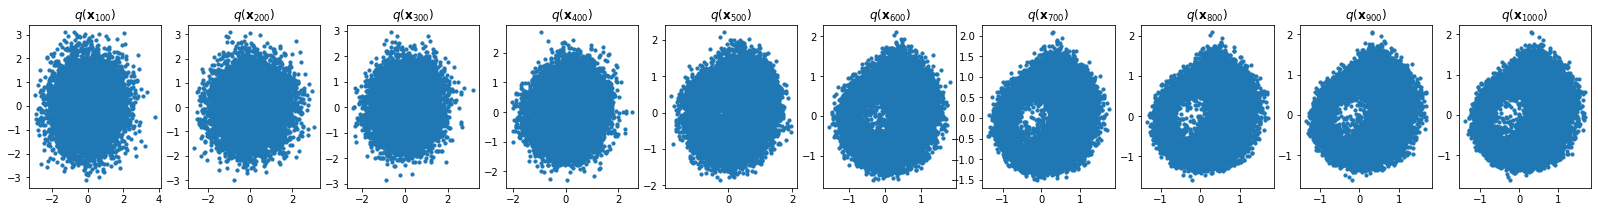

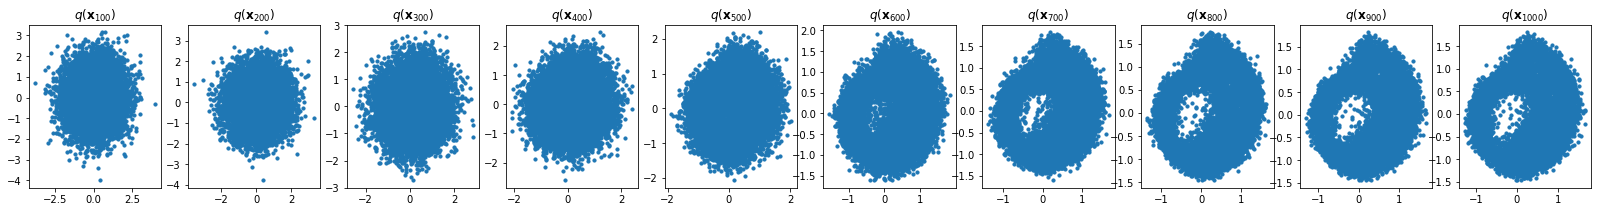

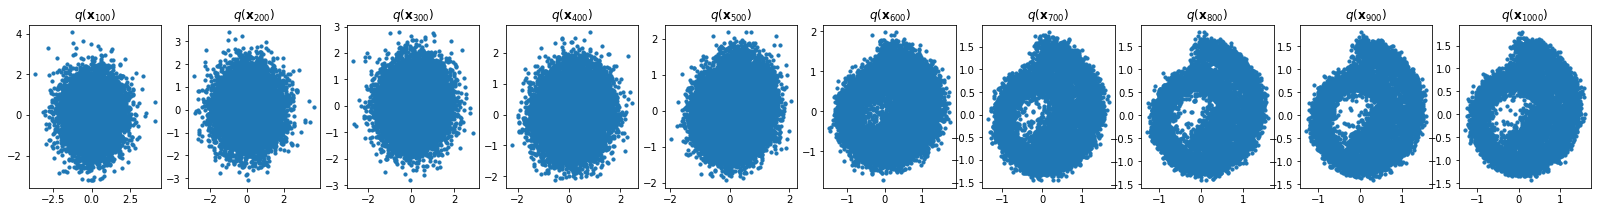

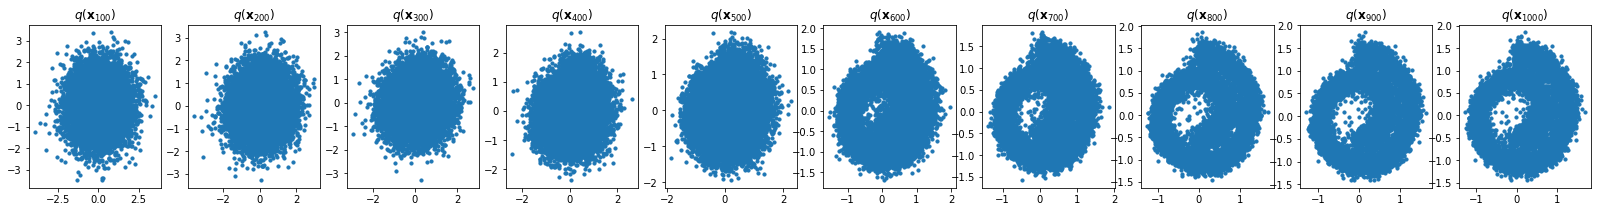

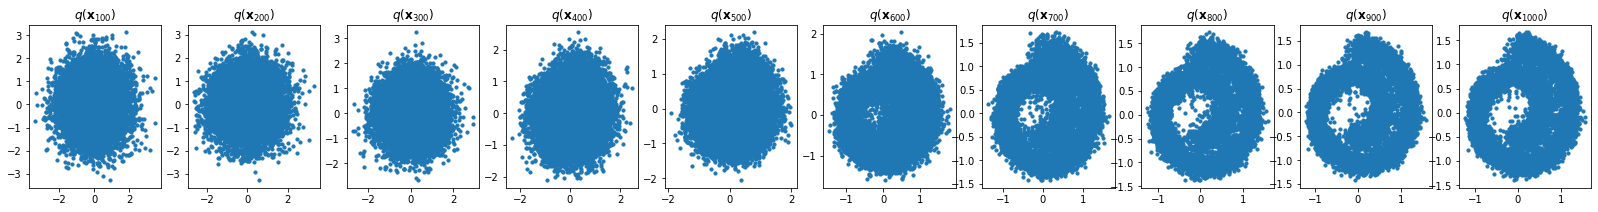

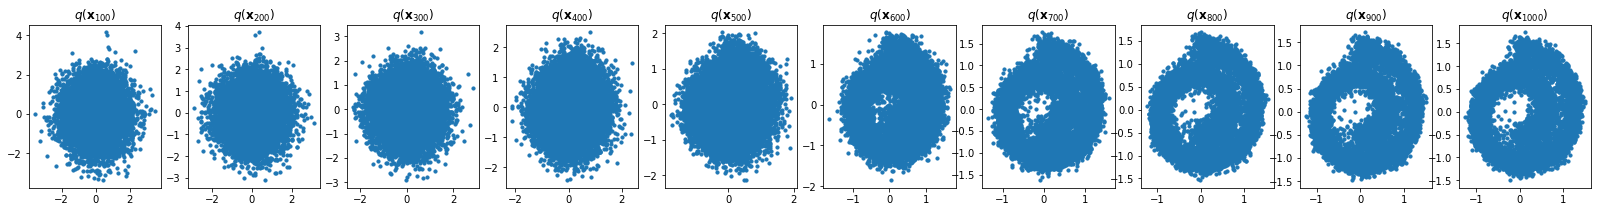

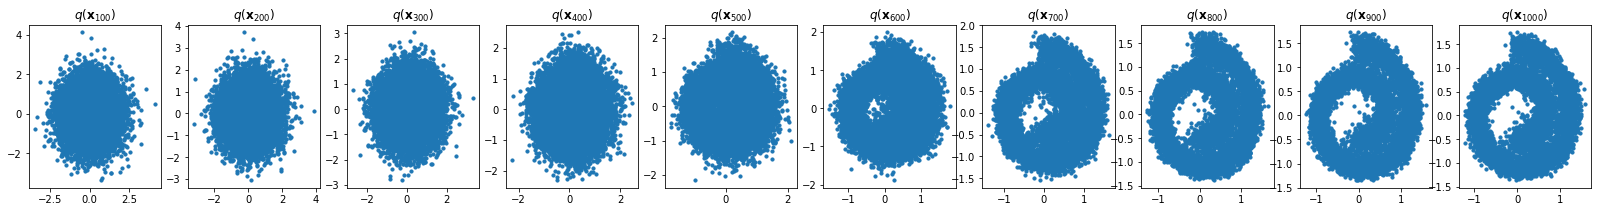

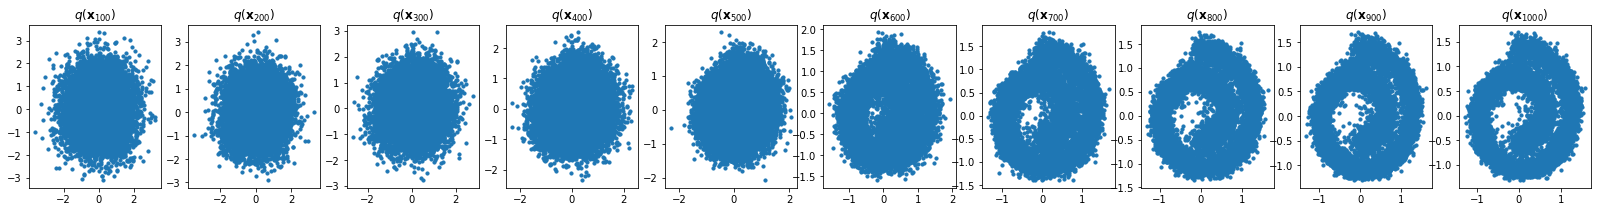

In [6]:
n_steps = 100

betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

# data
data = sample_batch(10**4).T
dataset = torch.tensor(data.T).float()

# create EMA model
model = ConditionalModel(n_steps)
ema = EMA(0.9)
ema.register(model)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# batch size
batch_size = 128

# train
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x,n_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
        
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape,n_steps,alphas)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            #axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

## 参考

<a id="ref1"/>

[1] [Ho, J., Jain, A., & Abbeel, P. (2020). _Denoising diffusion probabilistic models_. arXiv preprint arXiv:2006.11239.](https://arxiv.org/pdf/2006.11239)